## <span style='color:#ff5f27'> 📝 Imports</span>

In [1]:
import torch
import torch.nn as nn

import config
from functions.utils import show_segmentation, show_image
from functions.vqgan import load_vqgan_model, generate_iteration
from functions.t5 import encode_text

2024-09-11 19:01:03,432 INFO: generated new fontManager


## <span style='color:#ff5f27'> 🤖 VQGAN Loading</span>

In [2]:
# Load SFLCKR VQGAN
vqgan_model = load_vqgan_model(
    config.VQGAN_CONFIG_SFLCKR,
    config.VQGAN_CHECKPOINT_SFLCKR,
).to(config.DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
2024-09-11 19:01:11,313 INFO: number of parameters: 3.049329e+08
Restored from logs/2020-11-09T13-31-51_sflckr/model_ckpt/last.ckpt
✅ Done!


## <span style='color:#ff5f27'> 🌉 Transistor Loading</span>

In [5]:
class Transistor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.2):
        super(Transistor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc4 = nn.Linear(hidden_dim // 2, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.layer_norm3 = nn.LayerNorm(hidden_dim // 2)
    
    def forward(self, x):
        x1 = F.relu(self.fc1(x))
        x1 = self.dropout(x1)
        x1 = self.layer_norm1(x1)
        
        x2 = F.relu(self.fc2(x1))
        x2 = self.dropout(x2)
        x2 = self.layer_norm2(x2)
        x2 = x1 + x2  # Skip connection
        
        x3 = F.relu(self.fc3(x2))
        x3 = self.dropout(x3)
        x3 = self.layer_norm3(x3)
        
        return self.fc4(x3)

In [88]:
def load_transistor_model(model_path, hidden_dim):
    # Define model parameters
    input_dim = 1024  # Dimension of T5 output
    hidden_dim = hidden_dim 
    output_dim = 256 * 16 * 16  # Dimension of VQGAN latent space

    # Create model instance
    transistor_model = Transistor(input_dim, hidden_dim, output_dim).to(config.DEVICE)

    # Load the saved state dictionary
    transistor_model.load_state_dict(torch.load(model_path))

    # Set the model to evaluation mode
    transistor_model.eval()
    
    print('✅ Done!')

    return transistor_model

# Transistor Loading
transistor_model = load_transistor_model(
    'transistor/sflckr/best_transistor_model_0481.pth', 
    hidden_dim=2048,  #1536 | 2048
)

✅ Done!


## <span style='color:#ff5f27'> 🚀 Inference</span>

In [66]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

def load_and_process_segmentation(path, plot_segmentation=True, num_categories_expected=183, device='cuda', target_size=None):
    """
    Load a segmentation image, process it for VQGAN input, and resize to target dimensions.
    Args:
    path (str): Path to the segmentation image.
    plot_segmentation (bool): Whether to plot the segmentation.
    num_categories_expected (int): Number of categories the model expects.
    device (str): Device to use for tensor operations.
    target_size (tuple): Target size for the segmentation tensor (height, width).
    Returns:
    torch.Tensor: Processed and resized segmentation tensor.
    """
    segmentation = np.array(Image.open(path))
    
    num_categories_in_image = np.max(segmentation) + 1
    print(f"⛳️ Number of categories in segmentation image: {num_categories_in_image}")
    segmentation_one_hot = np.eye(num_categories_in_image)[segmentation]
    segmentation_tensor = torch.tensor(segmentation_one_hot.transpose(2, 0, 1)[None], 
                                       dtype=torch.float32, device=device)
    
    if num_categories_in_image < num_categories_expected:
        padding = torch.zeros((1, num_categories_expected - num_categories_in_image, 
                               *segmentation_tensor.shape[2:]), device=device)
        segmentation_tensor = torch.cat([segmentation_tensor, padding], dim=1)
    else:
        segmentation_tensor = segmentation_tensor[:, :num_categories_expected, :, :]
    
    if target_size:
        # Resize the segmentation tensor to the target size
        segmentation_tensor_resized = F.interpolate(segmentation_tensor, size=target_size, mode='nearest')

        print(f"⛳️ Resized segmentation tensor shape: {segmentation_tensor_resized.shape}")
    
    if plot_segmentation:
        show_segmentation(segmentation_tensor_resized)
        
    return segmentation_tensor_resized

In [67]:
IMAGE_ID = "2883773_881c197107_c"

mask_path = f"data/sflckr_segmentations/canada/{IMAGE_ID}.png"

config.INITIAL_IMAGE = mask_path

⛳️ Number of categories in segmentation image: 178
⛳️ Resized segmentation tensor shape: torch.Size([1, 182, 256, 256])


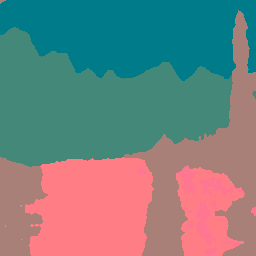

In [68]:
segmentation_tensor = load_and_process_segmentation(
    config.INITIAL_IMAGE, 
    plot_segmentation=True, 
    num_categories_expected=182,
    target_size=(256, 256),
)

In [69]:
def generate_image_from_text_mask(user_query, mask_path, transistor_model, vqgan_model, encode_text_fn, device, n_iterations=1):
    
    segmentation_tensor = load_and_process_segmentation(
        mask_path,
        plot_segmentation=True,
        device=vqgan_model.device,
        num_categories_expected=182,
        target_size=(256, 256),
    )        
    c_code_mask, c_indices_mask = vqgan_model.encode_to_c(segmentation_tensor)
    
    # Encode text
    text_latent, _ = encode_text_fn([user_query])
    text_latent = text_latent.mean(dim=1).to(device)  # Average over token dimension

    # Pass through Transistor
    with torch.no_grad():
        image_latent = transistor_model(text_latent)

    # Reshape
    image_latent = image_latent.view(1, 256, 16, 16)

    # Quantize (this step depends on VQGAN's specific implementation)
    c_code_text, _, [_, _, c_indices_text] = vqgan_model.first_stage_model.quantize(image_latent)

    z_indices = torch.randint(256, c_indices_text.shape, device=vqgan_model.device)
    initial_image = vqgan_model.decode_to_img(z_indices, c_code_text.shape)

    print("Initial random image:")
    show_image(initial_image)

    for iteration in range(n_iterations):
        print(f"⛳️ Starting iteration {iteration + 1}/{n_iterations}")
        
        if iteration % 2 == 0:
            c_code, c_indices = c_code_text, c_indices_text
        
        else:
            c_code, c_indices = c_code_mask, c_indices_mask
        
        final_image = generate_iteration(
            vqgan_model, 
            c_code, 
            c_indices, 
            z_indices, 
            temperature=config.TEMPERATURE, 
            top_k=config.TOP_K, 
            update_every=config.UPDATE_EVERY,
            iteration=iteration,
        )

    print("✅ All iterations completed.")
    
    return final_image


In [70]:
import torch
import torch.nn.functional as F

def generate_image_from_text_mask_weighted(user_query, mask_path, transistor_model, vqgan_model, encode_text_fn, device, n_iterations=5, initial_text_weight=0.3, final_text_weight=0.7):
    if mask_path:
        segmentation_tensor = load_and_process_segmentation(
            mask_path,
            plot_segmentation=True,
            device=vqgan_model.device,
            num_categories_expected=182,
            target_size=(256, 256),
        )        
        c_code_mask, c_indices_mask = vqgan_model.encode_to_c(segmentation_tensor)
    
    # Encode text
    text_latent, _ = encode_text_fn([user_query])
    text_latent = text_latent.mean(dim=1).to(device)  # Average over token dimension

    # Pass through Transistor
    with torch.no_grad():
        image_latent = transistor_model(text_latent)

    # Reshape
    image_latent = image_latent.view(1, 256, 16, 16)

    # Quantize (this step depends on VQGAN's specific implementation)
    c_code_text, _, [_, _, c_indices_text] = vqgan_model.first_stage_model.quantize(image_latent)
    
    print("c_code_text", c_code_text.shape, c_code_text.dtype)
    print("c_indices_text", c_indices_text.shape, c_indices_text.dtype)
    
    print("c_code_mask", c_code_mask.shape, c_code_mask.dtype)
    print("c_indices_mask", c_indices_mask.shape, c_indices_mask.dtype)
    
    c_code_combined = (c_code_mask + c_code_text) / 2
    c_indices_combined = (c_indices_mask + c_indices_text) / 2

    z_indices = torch.randint(256, c_indices_text.shape, device=vqgan_model.device)
    initial_image = vqgan_model.decode_to_img(z_indices, c_code_text.shape)

    print("Initial random image:")
    show_image(initial_image)

    for iteration in range(n_iterations):
        print(f"⛳️ Starting iteration {iteration + 1}/{n_iterations}")
        
        # Calculate a dynamic weight that gradually increases the text influence
        if n_iterations > 1:
            text_weight = initial_text_weight + (final_text_weight - initial_text_weight) * (iteration / (n_iterations - 1))
        else:
            text_weight = final_text_weight
        
        # Combine latents with dynamic weighting
        combined_c_code = (1 - text_weight) * c_code_mask + text_weight * c_code_text
        
        # For c_indices, we'll use the mask indices as a base and gradually introduce text indices
        combined_c_indices = torch.where(
            torch.rand_like(c_indices_mask.float()) < text_weight,
            c_indices_text,
            c_indices_mask
        )

        final_image = generate_iteration(
            vqgan_model, 
            combined_c_code, 
            combined_c_indices, 
            z_indices, 
            temperature=config.TEMPERATURE * (1 + iteration / max(n_iterations - 1, 1)),  # Avoid division by zero
            top_k=max(config.TOP_K - iteration, 1),  # Gradually decrease top_k
            update_every=config.UPDATE_EVERY,
            iteration=iteration,
        )
        
    print("✅ All iterations completed.")
    return final_image

🕰️ Time: 11.02 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


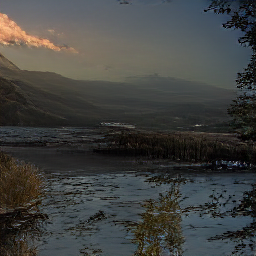

✅ All iterations completed.


In [71]:
user_query = """
A breathtaking night sky filled with twinkling stars and a vibrant Milky Way, 
arching over majestic snow-capped mountain peaks silhouetted against the cosmic backdrop
"""
# Starry mountain night

generated_image = generate_image_from_text_mask(
    user_query=user_query,
    mask_path=mask_path,
    transistor_model=transistor_model,
    vqgan_model=vqgan_model,
    encode_text_fn=encode_text,
    device=config.DEVICE,
    n_iterations=2,
)

🕰️ Time: 11.48 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


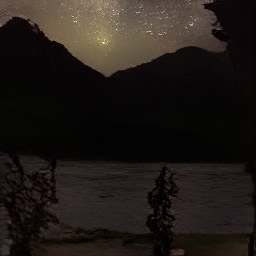

✅ All iterations completed.


In [72]:
user_query = """
A spectacular golden sunset painting the sky in shades of yellow, orange, and pink, 
casting a warm glow over a lush emerald-green forest of towering pines and ancient oaks
"""
# Golden forest sunset

generated_image = generate_image_from_text_mask(
    user_query=user_query,
    mask_path=mask_path,
    transistor_model=transistor_model,
    vqgan_model=vqgan_model,
    encode_text_fn=encode_text,
    device=config.DEVICE,
    n_iterations=2,
)

🕰️ Time: 11.46 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


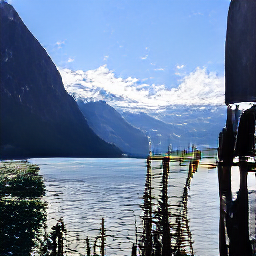

✅ All iterations completed.


In [73]:
user_query = """
A serene winter wonderland featuring a dense forest of evergreen trees heavily laden with pristine white snow, 
their branches bowing under the weight as sunlight sparkles off the icy crystals
"""
# Snowy evergreen forest

generated_image = generate_image_from_text_mask(
    user_query=user_query,
    mask_path=mask_path,
    transistor_model=transistor_model,
    vqgan_model=vqgan_model,
    encode_text_fn=encode_text,
    device=config.DEVICE,
    n_iterations=2,
)

🕰️ Time: 11.49 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


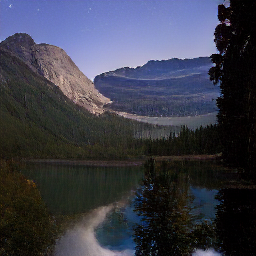

✅ All iterations completed.


In [74]:
user_query = """
A vast, azure ocean stretching to the horizon, with rolling waves in varying shades of blue and turquoise, 
cresting with white foam and reflecting the clear sky above
"""
# Rolling ocean waves

generated_image = generate_image_from_text_mask(
    user_query=user_query,
    mask_path=mask_path,
    transistor_model=transistor_model,
    vqgan_model=vqgan_model,
    encode_text_fn=encode_text,
    device=config.DEVICE,
    n_iterations=2,
)

🕰️ Time: 11.48 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


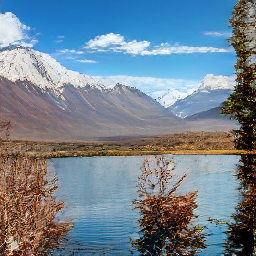

✅ All iterations completed.


In [75]:
user_query = """
An awe-inspiring mountain range with jagged, rocky peaks reaching towards the sky, their lower slopes covered in verdant forests, 
and a crystal-clear alpine lake nestled in the valley below
"""
# Mountain lake landscape

generated_image = generate_image_from_text_mask(
    user_query=user_query,
    mask_path=mask_path,
    transistor_model=transistor_model,
    vqgan_model=vqgan_model,
    encode_text_fn=encode_text,
    device=config.DEVICE,
    n_iterations=2,
)

🕰️ Time: 11.33 seconds
⛳️ Step: (15,15) | Local: (15,15) | Crop: (0:16,0:16)


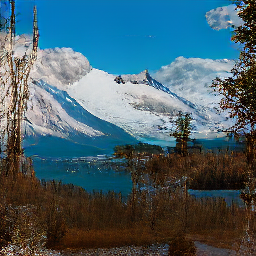

✅ All iterations completed.


In [90]:
user_query = """
A majestic, centuries-old oak tree with a thick, gnarled trunk and a sprawling canopy of vibrant green leaves, 
standing solitary in a sunlit meadow dotted with colorful wildflowers
"""
# Ancient oak meadow

generated_image = generate_image_from_text_mask(
    user_query=user_query,
    mask_path=mask_path,
    transistor_model=transistor_model,
    vqgan_model=vqgan_model,
    encode_text_fn=encode_text,
    device=config.DEVICE,
    n_iterations=2,
)

---